# Automatic differentiation with dual_autodiff

`dual_autodiff` is a Python package that performs automatic differentiation using dual numbers, it's main component is the `Dual` class. Once the package has been installed through the provided wheels or using "pip install -e ." within the root directories of both packages one can work with them as follows


In [1]:
from dual_autodiff.dual import Dual
from dual_x import Dual as Dual_x
import numpy as np
import matplotlib.pyplot as plt
from timeit import timeit

In [2]:
# Analytic function
def f(x):
    return np.log(np.sin(x)) + x**2*np.cos(x)
# Analytic derivative
def f_(x):
    return 1/np.tan(x) + 2*x*np.cos(x) - x**2*np.sin(x)
# Numeric derivative
def numeric_diff(f,x,h=1e-6):
    return (f(x+h)-f(x-h))/(2*h)

In [3]:
#Initializing a dual number
x=Dual(2.,1.)
y=Dual(3.,2.)

print((x+y))

Dual(real=5.0,dual=3.0)


In [4]:
#Performing a trignometric computation
print(x.sin())

Dual(real=0.9092974268256817,dual=-0.4161468365471424)


In [5]:
x= Dual(1.5,1.0)
z= Dual_x(1.5,1.0)

In [6]:
#Comparing computation times
%timeit f_(1.5)
%timeit numeric_diff(f,1.5)
%timeit x.sin().log() + x**2*x.cos()
%timeit z.sin().log() + z**2*z.cos()


5.28 μs ± 109 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
8.06 μs ± 1.01 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
8.61 μs ± 115 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
6.79 μs ± 145 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


One can clearly see that the computation time for the cythonized class is less than the pure Python class.

### Making sure we are computing the correct answer


In [7]:
print(f(1.5),f_(1.5))

0.15665054756073515 -1.9612372705533612


In [8]:
print(f(1.5),numeric_diff(f,1.5,1e-7))

0.15665054756073515 -1.9612372717525695


In [9]:
x= Dual(1.5,1)

diff= x.sin().log() + x**2*x.cos()
print(diff)

Dual(real=0.15665054756073515,dual=-1.9612372705533612)


In [10]:
x= Dual_x(1.5,1)

diff= x.sin().log() + x**2*x.cos()
print(diff)

Dual(real=0.15665054756073515,dual=-1.9612372705533612)


### Why do we avoid numeric methods?

Numeric methods lead to an error, in our case that error is proportional to the square of the step size, when computing derivatives using the chain rule this error compounds which can lead to errors when we compute the minima of our loss functions and such.

In [11]:
errs=[]
for i in range(1,6):
    for j in range(1,10):
        errs.append((j*10**-i,np.abs(f_(1.5)-numeric_diff(f,1.5,j*10**-i))))

errs= np.array(errs)

In [12]:
errs= np.log(errs)

slope of log graph: 1.990395085293052


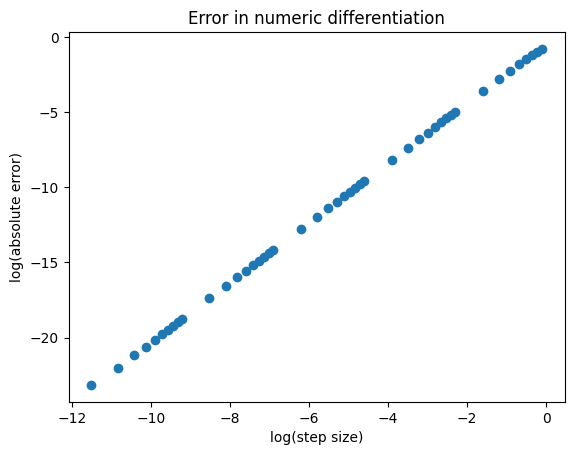

In [13]:
plt.scatter(errs[:,0],errs[:,1])
m,c= np.polyfit(errs[:,0],errs[:,1],1)
plt.title("Error in numeric differentiation")
plt.xlabel("log(step size)")
plt.ylabel("log(absolute error)")
print('slope of log graph:',m)

### Comparing cython with pure python

Now we will compare the efficiency of using a cythonized version of `dual_autodiff` with a pure Python implementation

In [14]:
a= Dual(2.0,1.0)
b= Dual_x(2.0,1.0)

In [15]:
order=['sum','diff','mult','div','sin','cos','tan','log','exp']
def test_time(a):
    ts= []
    ts.append(timeit(lambda: a+a,number=100000))
    ts.append(timeit(lambda: a-a,number=100000))
    ts.append(timeit(lambda: a*a,number=100000))
    ts.append(timeit(lambda: a/a,number=100000))
    ts.append(timeit(lambda: a.sin(),number=100000))
    ts.append(timeit(lambda: a.cos(),number=100000))
    ts.append(timeit(lambda: a.tan(),number=100000))
    ts.append(timeit(lambda: a.log(),number=100000))
    ts.append(timeit(lambda: a.exp(),number=100000))
    return ts

In [16]:
t_norm= test_time(a)
t_cy= test_time(b)

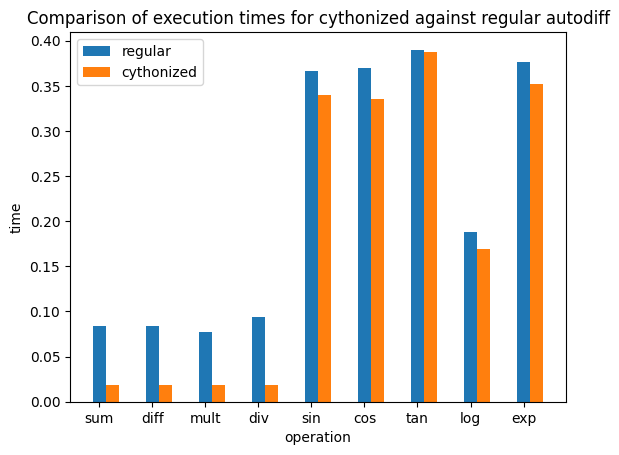

In [17]:
xs= np.arange(0,17,2)
width= 0.5
plt.bar(xs,t_norm,width=width,label="regular")
plt.bar(xs+width,t_cy,width=width,label="cythonized")
plt.xticks(xs,order)
plt.title("Comparison of execution times for cythonized against regular autodiff")
plt.ylabel("time")
plt.xlabel("operation")
plt.legend()
plt.show()

So what do we see? It is clear that cython seems to be much faster for implementations that involved pure python, like arithmetic operations, however, since we were using numpy for our algebraic manipulations, cython does not seem to amount to much of a difference since numpy is written in C to begin with